In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast 
from sklearn.inspection import permutation_importance
import geopy.distance as dist

def getKilometersFromCenter(data, city):
    kilometers = np.zeros(data.shape[0])
    if city == 'copenhagen':
        center =  [55.6761, 12.5683]
    elif city == 'stockholm':
        center =  [59.3293, 18.0686]
    elif city == 'london':
        center = [51.5074, -0.1272]
    elif city == 'paris':
        center = [48.8566, 2.3522]
    else:
        center = [52.5373, 13.3603]
    for i in range(data.shape[0]):
        # data[i, 0] = (data[i, 0]- center[0])*111
        # data[i, 1] = (data[i, 1] - center[1])*111
        # kilometers[i] = np.linalg.norm(data[i, 0]-data[i, 1])
        kilometers[i] = dist.geodesic(data[i], center).km
        if(data[i, 0] <  center[0]): 
            data[i, 0] = -dist.geodesic((data[i, 0], center[1]), center).km
        else: 
            data[i, 0] = dist.geodesic((data[i, 0], center[1]), center).km
        if(data[i, 1] <  center[1]):
            data[i, 1] = -dist.geodesic((center[0], data[i, 1]), center).km
        else:
            data[i, 1] = dist.geodesic((center[0], data[i, 1]), center).km
    return kilometers, data, center

def string_features_to_num(array):
    dictOfWords = { i : np.unique(array)[i] for i in range(0, len(np.unique(array)) ) }
    dictOfWords = {v: k for k, v in dictOfWords.items()}
    
    values = np.zeros(len(array))
    for i in range(len(array)):
        values[i] = dictOfWords.get(array[i])
        
    return values, dictOfWords

def selectPropertyType(type, X, y):
    xlist = []
    ylist = []
    for i in range(X.shape[0]):
        if(X[i,-5] == type):
            xlist.append(X[i,:])
            ylist.append(y[i])
    return np.array(xlist), np.array(ylist)

def oneHotEncodingPropertyType(type, X):
    isType = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        if(X[i] == type):
            isType[i] = 1.0
    return isType

def plotPredVsReal(yreal, ypred, limit):
    plt.scatter(yreal, ypred, label="pred vs true")
    plt.plot(yreal, yreal, label="y=x", c='red')
    plt.xlabel("y-real")
    plt.ylabel("y-pred")
    plt.xlim((0,limit))
    plt.ylim((0,limit))
    plt.legend()
    plt.show

def host_Since_fix(X):
    yearsSince = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        yearsSince[i] = 2022 - int(X[i].split('-')[0])
    return yearsSince

def plot_feature_importance(best_model, X, y, featureNames):
    permut = permutation_importance(best_model, X, y, scoring='r2')
    importance = permut.importances_mean
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importance)), importance)
    plt.gca().set(xticks=range(len(importance)), xticklabels = featureNames)
    plt.xticks(rotation=90)
    plt.show()

def plotCity(longAndLat, y):
    heatmapColors = np.clip(y, 0, 800)
    indexes = np.argsort(y)
    # c=scaler.fit_transform(y.reshape(-1,1))
    plt.scatter(longAndLat[indexes,1], longAndLat[indexes,0], c=heatmapColors[indexes], cmap=mpl.colormaps['hot'])
    plt.colorbar()
    plt.scatter(0, 0, label='center')
    plt.legend()
    plt.show()

def amenitiesOneHot(X, amenityName):
    amenities = []
    for i in range(X.shape[0]):
        amenities.append(ast.literal_eval(X[i,-1]))

    amenity = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for j in range(len(amenities[i])):
            if(amenities[i][j]==amenityName):
                amenity[i] = 1
    return amenity

def cleanBathroomFeature(X, y, featureNum):
    bathroomErr = []
    for i in range(X.shape[0]):
        try:
            X[i,featureNum] = float(X[i,featureNum].split()[0])
        except ValueError:
            bathroomErr.append(i)
    bathroomErr = np.array(bathroomErr)
    X = np.delete(X, bathroomErr, axis=0)
    y = np.delete(y, bathroomErr)
    return X, y

def cleanCurrency(y, city):
    exchange =1
    if city=='copenhagen': exchange = 0.1579
    elif city=='stockholm': exchange = 0.088507
    elif city=='london': exchange = 1.1594
    else: exchange = 1.0151

    for i in range(len(y)):
        y[i] = float(re.sub(",", "", (y[i][1:])))*exchange
    return y

In [2]:
def getCityData_vol2(city):
    data = pd.read_csv(('listings/listings_' + city + '.csv.gz'), compression='gzip')
    data = data[['number_of_reviews_ltm','bedrooms', 'accommodates', 'availability_90', 'beds', 'reviews_per_month', 'review_scores_value', 'calculated_host_listings_count', 'property_type', 'review_scores_location', 'latitude', 'longitude', 'price']]

    data = data.dropna()

    datanp = np.array(data)
    #removing all listings without reviews in the last 12 months
    datanp = datanp[datanp[:,0] != 0]
    datanp = datanp[:,1:]

    
    X = datanp[:,:-1]
    y = datanp[:,-1]

    # X, y = cleanBathroomFeature(X, y, 1)
    
    #converting local currency to USD based on exhcange rates in august 2022
    y = cleanCurrency(y, city)

    # removing the 10 least and 10 most expensive properties
    X = X[np.argsort(y)[10:-10], :]
    y = y[np.argsort(y)[10:-10]]


    
    latAndLong = X[:,-2:]
#     print(latAndLong)
    kilometers, longAndLat, center = getKilometersFromCenter(latAndLong, city)
    X = X[:,:-2]

    X = np.hstack((X, kilometers.reshape(-1,1)));

    #gathering different types of properties
    X[:,7], propertytype_dict = string_features_to_num(X[:, 7])
    onehotSource = X[:,7]
    X = np.delete(X, 7, axis=1)
    

    isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire rental unit'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))
    isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire condo'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))
    isType = oneHotEncodingPropertyType(propertytype_dict.get('Private room in rental unit'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))


#     X = np.hstack((np.hstack((X, kilometers.reshape(-1,1))), longAndLat))

    return X, y, latAndLong    

In [3]:
featureDict = {0: 'accommodates', 1: 'bathrooms', 2: 'bedrooms', 3: 'beds', 4: 'review_scores_rating', 5: 'review_scores_location',
6: 'review_scores_value', 7: 'review_scores_cleanliness', 8: 'reviews_per_month', 9: 'number_of_reviews', 10: 'calculated_host_listings_count', 
11: 'minimum_nights', 12: 'availability_90', 13: 'Entire rental unit', 14: 'Entire condo', 15: 'Private room in rental unit', 16: 'Private patio or balcony', 
17: 'TV', 18: 'Wifi', 19: 'Bed linens', 20: 'Breakfast', 21: 'Bathtub', 22: 'Washer', 23: 'Elevator', 24: 'Pool', 25: 'Km_from_center', 26: 'km_from_latitude', 
27: 'km_from_longitude', 28: 'Host_years'}


featureNames = np.array(list(featureDict.items()))
featureNames = featureNames[:,1]

In [5]:
lX, ly, _ = getCityData_vol2('london')
# cX, cy, _ = getCityData_vol2('copenhagen')
# sX, sy, _ = getCityData_vol2('stockholm')
# bX, by, _ = getCityData_vol2('berlin')
pX, py, _ = getCityData_vol2('paris')



In [6]:
print(np.mean(ly), np.mean(py))

208.16355613566364 186.13536646259217


In [23]:
# Neural network on chosen city
city_x = lX
city_y = ly
# cx = np.concatenate((cX,lX), axis=0)
# cY = np.concatenate((cy,ly), axis=0)
cx = np.asarray(city_x).astype('float32')
cY = np.asarray(city_y).astype('float32')



cX_train, cX_testval, cy_train, cy_testval = train_test_split(cx, cY, test_size=0.20)
cX_test, cX_val, cy_test, cy_val = train_test_split(cX_testval, cy_testval, test_size=0.5)

print(cX_train.shape, cX_test.shape, cX_val.shape)

(23328, 12) (2916, 12) (2916, 12)


In [24]:
#normalize our data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
cx_train_sc = X_scaler.fit_transform(cX_train)
cx_val_sc = X_scaler.transform(cX_val)
cx_test_sc = X_scaler.transform(cX_test)

cx_train_sc.shape

(23328, 12)

In [19]:
!pip3 install tensorflow
import tensorflow as tf


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached tensorflow-2.11.0-cp310-cp310-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.11.0-cp310-cp310-win_amd64.whl (266.3 MB)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 64)                832       
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 256)               16640     
                                                                 
 dense_31 (Dense)            (None, 1)                 257       
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
5832/5832 [==============================] - 22s 4ms/step - loss: 0.3062 - msle: 0.3062 - val_loss: 0.2399 - val_msle: 0.2399
Epoch 2/100
5832/5832 [================

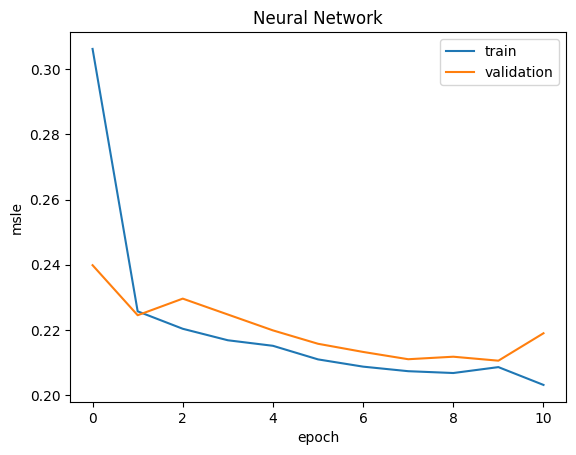

92/92 [==============================] - 0s 3ms/step
London validation set
Test r2: 0.4395


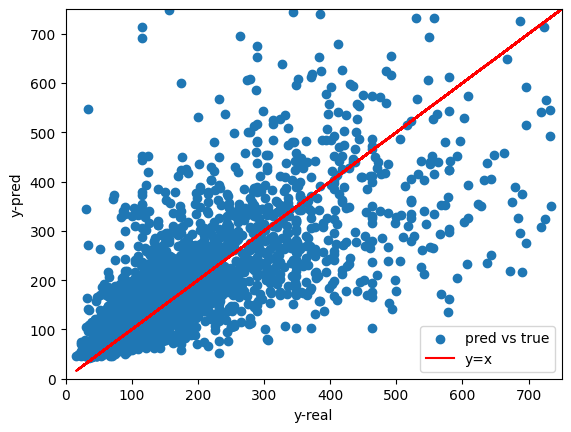

In [38]:
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adagrad

input_dim = cx_train_sc.shape[1]
# SGD: larger learning rate (0.06), Adam: smaller learning rate
lr = 0.005
p = 0.2
model = Sequential()
#found 16 to be optimal
model.add(Dense(units=64, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
# p = 0.2 optimal
model.add(Dropout(p))
model.add(Dense(units=256, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(p))
# model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
print(model.summary())
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_msle'
                        , patience = 3
                        , verbose = 1
                        , mode = 'auto'
                        , min_delta = 0.001)

num_epochs = 100

#larger --> increase stockholm score
#smaller --> increase copen score
# too large / too small, predictions converge to same value
b_size = 4
#optimizers: adam, sgd, 
model.compile(loss="msle", optimizer=Adam(learning_rate=lr), metrics = ['msle'])

history = model.fit(cx_train_sc, cy_train,
                   batch_size = b_size,
                   epochs = num_epochs,
                   verbose = 1,
                   validation_data=(cx_val_sc, cy_val),
                   callbacks = [callback])

import matplotlib.pyplot as plt
plt.plot(history.history['msle'])
plt.plot(history.history['val_msle'])
plt.ylabel('msle')
plt.xlabel('epoch')
plt.title('Neural Network')
plt.legend(['train', 'validation'])
plt.show()

c_pred = model.predict(cx_val_sc)
print("London validation set")
plotPredVsReal(cy_val, c_pred, 750)
print("Test r2:", round(r2_score(cy_val, c_pred),4))

92/92 [==============================] - 0s 4ms/step
London test set
Test r2: 0.5424


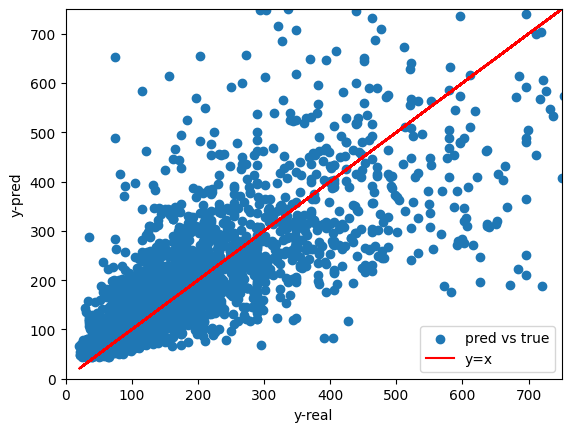

In [39]:
from sklearn.metrics import r2_score
c_pred = model.predict(cx_test_sc)
print("London test set")
plotPredVsReal(cy_test, c_pred, 750)
print("Test r2:", round(r2_score(cy_test, c_pred),4))

858/858 [==============================] - 2s 3ms/step
Paris evaluated on London model
Test r2: 0.2962


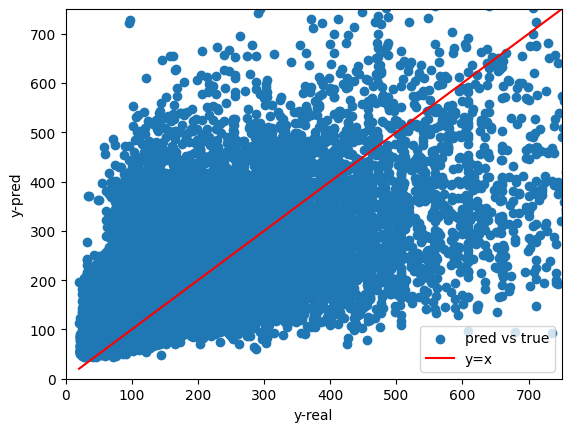

In [29]:
sx, sY = np.asarray(pX).astype('float32'), np.asarray(py).astype('float32')
sx_sc = X_scaler.transform(sx)
s_pred = model.predict(sx_sc)
print("Paris evaluated on London model")
plotPredVsReal(sY, s_pred, 750)
print("Test r2:", round(r2_score(sY, s_pred),4))